#### Importing required libraries

In [147]:
import numpy as np # Numerical Python
import pandas as pd # Data analysis and manipulation tool 
import matplotlib.pyplot as plt # Visualization
import seaborn as sns

# preprocess data
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# feature selection
from sklearn.decomposition import PCA

# model evaluation
from sklearn.metrics import auc, roc_curve, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

# machine learning models
from sklearn.linear_model import LogisticRegression # classification model
import statsmodels.api as sm

## Question 1

- Forward selection implementation 
- AUC evaluation for new feature selection
- binary classification (expensive phone, cheap phone)

- **True positive rate:** این متریک با استفاده از مثبت واقعی و منفی کاذب طبق فرمول زیر محاسبه می شود.

<img src="images/tpr.png" width="200"/>

- **False positive rate:** این متریک با استفاده از مثبت کاذب و منفی واقعی طبق فرمول زیر محاسبه می شود.

<img src="images/fpr.png" width="200"/>

In [21]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

### ROC Curve From Scratch

- An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:
    - True Positive Rate
    - False Positive Rate


- An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

<img src="images/ROCCurve.svg" width="350"/>
<center><strong>Figure 3. TP vs. FP rate at different classification thresholds.<strong\><center/>

- To compute the points in an ROC curve, we could evaluate a logistic regression model many times with different classification thresholds, but this would be inefficient. Fortunately, there's an efficient, sorting-based algorithm that can provide this information for us, called AUC.

In [22]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

In [23]:
def roc_curve_visualization(prob_vector, y_test, partitions):
    sns.set()
    plt.figure(figsize=(15,7))

    ROC = roc_from_scratch(prob_vector, y_test, partitions=partitions)

    plt.scatter(ROC[:,0], ROC[:,1], color='#0F9D58',s=100)
    plt.title('ROC Curve', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

In [24]:
def roc_curve_animated(prob_vector, y_test):
    from celluloid import Camera
    
    camera = Camera(plt.figure(figsize=(17,9)))
    for i in range(30):
        ROC = roc_from_scratch(prob_vector, y_test,partitions=(i+1)*5)
        
        plt.scatter(ROC[:,0], ROC[:,1], color='#0F9D58',s=100)
        plt.title('ROC Curve', fontsize=20)
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)

        camera.snap()

#     anim = camera.animate(blit=True,interval=300)
#     anim.save('scatter.gif')

### AUC From Scratch

- The area under the curve in the ROC graph is the primary metric to determine if the classifier is doing well. The higher the value, the higher the model performance. This metric’s maximum theoric value is 1, but it’s usually a little less than that.

- The AUC can be calculated for functions using the integral of the function between 0 and 1.

- But in this case, it’s not that simple to create a function. Nonetheless, a good approximation is to calculate the area, separating it into smaller pieces (rectangles and triangles).

#### AUC: Area Under the ROC Curve
- AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).

<img src="images/AUC.svg" width="350"/>
<center><strong>Figure 4. AUC (Area under the ROC Curve).<strong\><center/>

- AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions:
<img src="images/AUCPredictionsRanked.svg" width="750"/>
<center><strong>Figure 5. Predictions ranked in ascending order of logistic regression score.<strong\><center/>

- AUC represents the probability that a random positive (green) example is positioned to the right of a random negative (red) example.

- AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

- AUC is desirable for the following two reasons:

     - AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
     - AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

- However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

    - Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

    - Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.


In [25]:
def auc_from_scratch(y_test, prob_vector, partitions):
    partitions = 100
    
    ROC = roc_from_scratch(prob_vector, y_test, partitions=partitions)
    fpr, tpr = ROC[:, 0], ROC[:, 1]
    
    rectangle_roc = 0
    for k in range(partitions):
            rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
    rectangle_roc
    
    return rectangle_roc

### **There are three types of feature selection techniques :**

  1. Filter methods
  2. Wrapper methods
  3. Embedded methods


### Difference between Filter, Wrapper, and Embedded Methods for Feature Selection

<img src="images/feature_selection_compare_different_methods.png">

#### Note:
- In our case, we utilize `Wrapper method`

In [26]:
def forward_selection_with_auc(x, y, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=79)
    initial_features = x.columns.tolist()
    best_features = []

    while len(initial_features)>0:
        print("ok")
        auc_value = {}
        remaining_features = list(set(initial_features) - set(best_features))
        new_x_train = x_train[remaining_features]
        new_x_test = x_test[remaining_features]
        
        if len(best_features) == 0:
            for new_column in remaining_features:
                model = LogisticRegression().fit(new_x_train[new_column].to_numpy().reshape(-1, 1), y_train)
                y_predict = model.predict(new_x_test[new_column].to_numpy().reshape(-1, 1))
                auc_value[new_column] = auc_from_scratch(y_test, y_predict, 100)
        
            max_auc_value = max(auc_value)
            
            print(auc_value[max_auc_value])
    
            best_features.append(max_auc_value)

        else :
            best_x_train = x_train[best_features]
            best_x_test = x_test[best_features]
        
            for new_column in remaining_features:
                model = LogisticRegression().fit(best_x_train.join(new_x_train[new_column]), y_train)
                y_predict = model.predict(best_x_test.join(new_x_test[new_column]))
                auc_value[new_column] = auc_from_scratch(y_test, y_predict, 100)
            
            max_auc_value = max(auc_value)
            
            model = LogisticRegression().fit(best_x_train, y_train)
            y_predict = model.predict(best_x_test)
            best_auc_value = auc_from_scratch(y_test, y_predict, 100)
            
            print(auc_value[max_auc_value])
            print(best_auc_value)
            best_features.append(max_auc_value)
            if(best_auc_value<auc_value[max_auc_value]):
                best_features.append(max_auc_value)
            else:
                break

    return best_features

In [27]:
def forward_selection_with_auc2(x, y, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=79)
    initial_features = x.columns.tolist()
    best_features = []

    while len(initial_features)>0:
        print("ok")
        auc_value = {}
        remaining_features = list(set(initial_features) - set(best_features))
        new_x_train = x_train[remaining_features]
        new_x_test = x_test[remaining_features]
        
        if len(best_features) == 0:
            for new_column in remaining_features:
                model = LogisticRegression().fit(new_x_train[new_column].to_numpy().reshape(-1, 1), y_train)
                y_predict = model.predict(new_x_test[new_column].to_numpy().reshape(-1, 1))
                fpr, tpr, thresholds = roc_curve(y_test, y_predict)
                auc_value[new_column] = auc(fpr, tpr)
        
            max_auc_value = max(auc_value)
            
            print(auc_value[max_auc_value])
    
            best_features.append(max_auc_value)

        else :
            best_x_train = x_train[best_features]
            best_x_test = x_test[best_features]
        
            for new_column in remaining_features:
                model = LogisticRegression().fit(best_x_train.join(new_x_train[new_column]), y_train)
                y_predict = model.predict(best_x_test.join(new_x_test[new_column]))
                fpr, tpr, thresholds = roc_curve(y_test, y_predict)
                auc_value[new_column] = auc(fpr, tpr)
            
            max_auc_value = max(auc_value)
            
            model = LogisticRegression().fit(best_x_train, y_train)
            y_predict = model.predict(best_x_test)
            best_auc_value = auc_from_scratch(y_test, y_predict, 100)
            
            print(auc_value[max_auc_value])
            print(best_auc_value)
            best_features.append(max_auc_value)
            if(best_auc_value<auc_value[max_auc_value]):
                best_features.append(max_auc_value)
            else:
                break

    return best_features

In [28]:
def forward_selection(x, y, significance_level=0.05):
    initial_features = x.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype=np.float64)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(x[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

## EDA 

### Total features


- battery_power : Total energy a battery can store in one time measured in mAh
- blue : Has bluetooth or not
- clock_speed : speed at which microprocessor executes instructions
- dual_sim : Has dual sim support or not
- fc : Front Camera mega pixels
- four_g : Has 4G or not
- int_memory : Internal Memory in Gigabytes
- m_dep : Mobile Depth in cm
- mobile_wt : Weight of mobile phone
- n_cores : Number of cores of processor
- pc : Primary Camera mega pixels
- px_height : Pixel Resolution Height
- px_width : Pixel Resolution Width
- ram : Random Access Memory in Megabytes
- sc_h : Screen Height of mobile in cm
- sc_w : Screen Width of mobile in cm
- talk_time : longest time that a single battery charge will last when you are
- three_g : Has 3G or not
- touch_screen : Has touch screen or not
- wifi : Has wifi or not

In [29]:
# reading data from .csv file
df = pd.read_csv("dataset/train.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [31]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [32]:
# Seperate dataset into x(train set) , y(target set)
x = df.drop(["price_range"], axis=1)
y = df["price_range"]

# note : we need to change our y column into binary class (expensive=1 , cheap=1)
# In order to Binarize the y column we set our threshold value to the mean value
binary_y = np.array(y>1, dtype=bool)*1
binary_y[:10]

array([0, 1, 1, 1, 0, 0, 1, 0, 0, 0])

In [33]:
# distribution of binaries
np.unique(binary_y, return_counts=True)

(array([0, 1]), array([1000, 1000], dtype=int64))

In [34]:
forward_selection_with_auc(x, binary_y)

ok
1.0
ok
0.48958333333333337
1.0


['wifi', 'touch_screen']

In [35]:
forward_selection_with_auc2(x, binary_y)

ok
0.5
ok
0.5140224358974359
1.0


['wifi', 'touch_screen']

In [36]:
forward_selection(x, binary_y)

['ram', 'battery_power', 'px_width', 'px_height', 'n_cores']

## Question 2

- utilize previous section code as feature selector and then apply a logistic model on selected features
- evaluate model with f1-score, recall and precision metrics
- So I did it carefully......

#### AUC

In [37]:
new_x = df[['wifi', 'touch_screen']]
# train test split dataset
x_train, x_test, y_train, y_test = train_test_split(new_x, binary_y, test_size=0.2, random_state=79)

In [38]:
# Create model
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.515

In [39]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       192
           1       0.53      0.54      0.54       208

    accuracy                           0.52       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.52      0.51       400



#### P-value

In [40]:
new_x = df[['ram', 'battery_power', 'px_width', 'px_height', 'n_cores']]
# train test split dataset
x_train, x_test, y_train, y_test = train_test_split(new_x, binary_y, test_size=0.2, random_state=79)

In [41]:
# Create model
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9925

In [42]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       192
           1       1.00      0.99      0.99       208

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



## Question 3

- Use PCA algorithm in way that number your components is same as number of selected features in q1
- Alter the dataset

## Question 4

- Use altered dataset from previous section 
- Apply a logistic regression on dataset
- evaluate model with f1-score, recall and precision metrics 

In [43]:
from sklearn.preprocessing import StandardScaler
Standard_x = StandardScaler().fit_transform(x)

#### AUC

In [44]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [45]:
principalDf.head()

,principal component 1,principal component 2
0,430.597094,-795.788231
1,504.984735,696.622368
2,473.329828,763.942136
3,639.822324,779.691180
4,-718.985184,382.304525


In [46]:
# train test split dataset
x_train, x_test, y_train, y_test = train_test_split(principalDf, binary_y, test_size=0.2, random_state=79)

In [47]:
# Create model
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.94

In [48]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       192
           1       0.95      0.93      0.94       208

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



#### P-value

In [49]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

In [50]:
# train test split dataset
x_train, x_test, y_train, y_test = train_test_split(principalDf, binary_y, test_size=0.2, random_state=79)

In [51]:
# Create model
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9875

In [52]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       192
           1       0.98      1.00      0.99       208

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



## Question 5

- Feature engineering is one of the most important parts of machine learning processes.
- Perform the following on the dataset.

**1.** Use the binning method on the battery power feature. (Consider at least three different sizes for the bins and even consider the size of the bins unequal.

**2.** Apply one hot encoding to categorical features in the database. And explain why we should use this encoding commonly?

**3.** Check if the use of transformations such as log transform or exponential transformation is applicable here? In general, why do we use such transformations? (In this section, you are allowed to apply another transformation if you consider it appropriate. This section will give you a score. Be sure to state the reason for using the used transformation.

**4.** Create a new feature called the area or volume of the phone

 ## Question 6
 
- Create a logistic regression model for each of the previous question modes and check results.
- Apply all 5 modes together once and run the logistic regression model on them.
- Report the results of these models

### Binning
- Three different types of binning

#### Type1

In [88]:
x = df.drop(["price_range"], axis=1)
x["battery_power"].value_counts(bins=3)

(499.502, 1000.0]    697
(1499.0, 1998.0]     662
(1000.0, 1499.0]     641
Name: battery_power, dtype: int64

In [89]:
bins_1 = np.array([0, 1000.0, 1499.0, 2000])
digitized_1 = np.digitize(x["battery_power"], bins_1)

In [90]:
x["battery_power"] = digitized_1
x["battery_power"].value_counts()

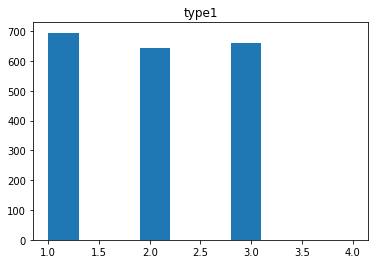

In [60]:
plt.hist(digitized_1)
plt.title("type1")
plt.show()

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, binary_y, test_size=0.2, random_state=79)
# Create model
model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9825

In [94]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       192
           1       0.98      0.99      0.98       208

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



#### Type2

In [95]:
x = df.drop(["price_range"], axis=1)
x["battery_power"].value_counts(bins=4)

(499.502, 875.25]    537
(1623.75, 1998.0]    490
(1249.5, 1623.75]    489
(875.25, 1249.5]     484
Name: battery_power, dtype: int64

In [96]:
bins_2 = np.array([0, 875.25, 1249.5, 1623.75, 2000])
digitized_2 = np.digitize(x["battery_power"], bins_2)

In [97]:
x["battery_power"] = digitized_2
x["battery_power"].value_counts()

1    537
4    490
3    489
2    484
Name: battery_power, dtype: int64

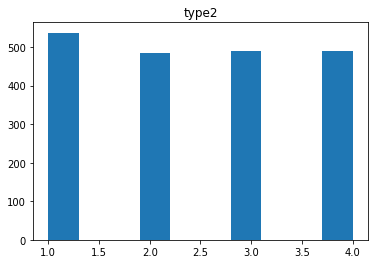

In [98]:
plt.hist(digitized_2)
plt.title("type2")
plt.show()

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, binary_y, test_size=0.2, random_state=79)
# Create model
model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.985

In [100]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       192
           1       0.99      0.99      0.99       208

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



#### Type3

In [102]:
x = df.drop(["price_range"], axis=1)
x["battery_power"].value_counts(bins=5)

(499.502, 800.4]    422
(800.4, 1099.8]     409
(1698.6, 1998.0]    400
(1399.2, 1698.6]    394
(1099.8, 1399.2]    375
Name: battery_power, dtype: int64

In [103]:
bins_3 = np.array([0, 800.4, 1099.8, 1399.2, 1698.6, 2000])
digitized_3 = np.digitize(x["battery_power"], bins_3)

In [104]:
x["battery_power"] = digitized_3
x["battery_power"].value_counts()

1    422
2    409
5    400
4    394
3    375
Name: battery_power, dtype: int64

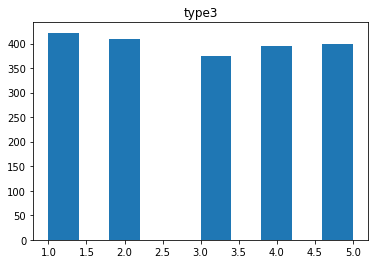

In [105]:
plt.hist(digitized_3)
plt.title("type3")
plt.show()

In [106]:
x_train, x_test, y_train, y_test = train_test_split(x, binary_y, test_size=0.2, random_state=79)
# Create model
model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9875

In [107]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       192
           1       0.98      1.00      0.99       208

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



### OneHot Encoder

One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector.


<img src="images/One_Hot_Encoding.png" width="500"/>


One hot encoding makes our training data more useful and expressive, and it can be rescaled easily. By using numeric values, we more easily determine a probability for our values. In particular, one hot encoding is used for our output values, since it provides more nuanced predictions than single labels.

In [116]:
new_x = df.drop(["price_range"], axis=1)

In [117]:
# finding categorical features (binary values can be considered as categorical features!)
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [118]:
df[['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].head()

,blue,dual_sim,four_g,three_g,touch_screen,wifi
0,0,0,0,0,0,1
1,1,1,1,1,1,0
2,1,1,1,1,1,0
3,1,0,0,1,0,0
4,1,0,1,1,1,0


In [119]:
# Turn the categories into numbers 
categorcal_features = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                one_hot,
                                categorcal_features)],
                                remainder="passthrough")

onehot_encoding_x = transformer.fit_transform(new_x)
onehot_encoding_x

array([[ 1.,  0.,  1., ...,  9.,  7., 19.],
       [ 0.,  1.,  0., ..., 17.,  3.,  7.],
       [ 0.,  1.,  0., ..., 11.,  2.,  9.],
       ...,
       [ 1.,  0.,  0., ...,  9.,  1.,  5.],
       [ 1.,  0.,  1., ..., 18., 10., 19.],
       [ 0.,  1.,  0., ..., 19.,  4.,  2.]])

In [112]:
onehot_encoding_x.shape

(2000, 26)

In [113]:
x_train, x_test, y_train, y_test = train_test_split(onehot_encoding_x, binary_y, test_size=0.2, random_state=79)

In [114]:
# Create model
model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9875

In [115]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       192
           1       0.99      0.99      0.99       208

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



### Log transform

#### Visually Inspect the Distribution of Your Variables

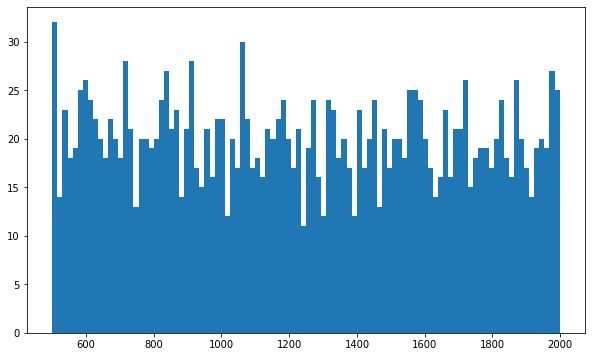

In [120]:
df["battery_power"].hist(grid=False, figsize=(10, 6), bins=100);

In [121]:
df["battery_power"].agg(['skew', 'kurtosis']).transpose()

skew        0.031898
kurtosis   -1.224144
Name: battery_power, dtype: float64

- Skewness
    - Fairly Symmetrical	-0.5 to 0.5
    - Moderate Skewed	-0.5 to -1.0 and 0.5 to 1.0
    - Highly Skewed	< -1.0 and > 1.0

In [122]:
new_df = df
new_df.insert(len(new_df.columns), 'battery_power_log', np.log(df['battery_power']))

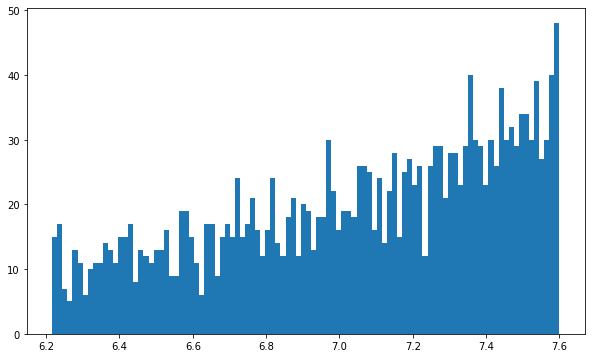

In [123]:
new_df["battery_power_log"].hist(grid=False, figsize=(10, 6), bins=100);

In [124]:
new_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,battery_power_log
0,842,0,2.2,0,1,0,7,0.6,188,2,...,756,2549,9,7,19,0,0,1,1,6.735780
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,1988,2631,17,3,7,1,1,0,2,6.928538
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1716,2603,11,2,9,1,1,0,2,6.333280
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1786,2769,16,8,11,1,0,0,2,6.421622
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1212,1411,8,2,15,1,1,0,1,7.507141


In [125]:
new_x = new_df.drop(["price_range", "battery_power"], axis=1)

In [126]:
# train test split dataset
x_train, x_test, y_train, y_test = train_test_split(new_x, binary_y, test_size=0.2, random_state=79)

In [127]:
# Create model
model = LogisticRegression(solver='newton-cg', max_iter=1000)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9775

In [128]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       192
           1       0.97      0.99      0.98       208

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



### New feature creation

- ph_vol = phone volume (cm^3)

In [129]:
new_df = df
new_df['ph_vol'] = df['m_dep']* df['sc_h']* df['sc_w']

In [130]:
new_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,battery_power_log,ph_vol
0,842,0,2.2,0,1,0,7,0.6,188,2,...,2549,9,7,19,0,0,1,1,6.735780,37.8
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,2631,17,3,7,1,1,0,2,6.928538,35.7
2,563,1,0.5,1,2,1,41,0.9,145,5,...,2603,11,2,9,1,1,0,2,6.333280,19.8
3,615,1,2.5,0,0,0,10,0.8,131,6,...,2769,16,8,11,1,0,0,2,6.421622,102.4
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1411,8,2,15,1,1,0,1,7.507141,9.6


In [131]:
# Seperate dataset into x(train set) , y(target set)
x = new_df.drop(["price_range"], axis=1)

In [132]:
x_train, x_test, y_train, y_test = train_test_split(x, binary_y, test_size=0.2, random_state=79)

In [133]:
# Create model
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.975

In [134]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       192
           1       0.97      0.98      0.98       208

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



## Question 7 

- Try to make a decision of the tree using the packages on the proposed dataset and perform the pruning of the trees that are also mentioned in the descriptive questions in your model.
- check whether this pruning has affected your results.

In [135]:
from sklearn.tree import DecisionTreeClassifier

In [151]:
def plot_confusionmatrix(y_train_pred,y_train,dom, classes):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

In [136]:
# Seperate dataset into x(train set) , y(target set)
x = df.drop(["price_range"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, binary_y, test_size=0.2, random_state=79)

In [137]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train, y_train)
dt_model.score(x_test, y_test)

0.945

Test Confusion matrix


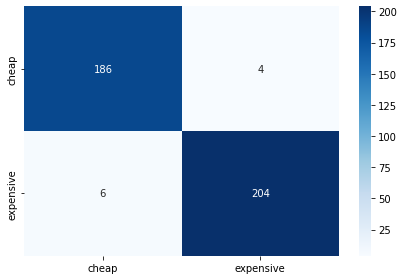

In [154]:
classes = ['cheap','expensive']
plot_confusionmatrix(y_preds,y_test,'Test',classes)

In [138]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       192
           1       0.97      0.98      0.98       208

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400



In [141]:
dt_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

#### Pre pruning techniques

- Pre pruning is nothing but stoping the growth of decision tree on an early stage. For that we can limit the growth of trees by setting constrains. We can limit parameters like max_depth , min_samples etc.

- An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performace on test data.

- As of now we will control these parameters

    - max_depth: maximum depth of decision tree
    - min_sample_split: The minimum number of samples required to split an internal node:
    - min_samples_leaf: The minimum number of samples required to be at a leaf node.

In [175]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4,5,6],
         'min_samples_leaf': [1,2,3,4,5,6,7,8,9]}

clf = DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)
model = gcv.best_estimator_
print(gcv.best_estimator_)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)


In [176]:
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.97

In [177]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       192
           1       0.98      0.96      0.97       208

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



Test Confusion matrix


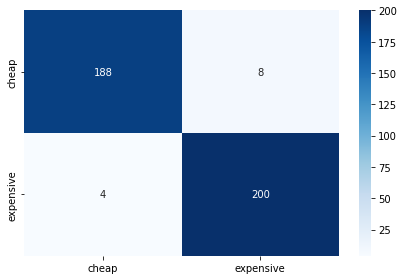

In [178]:
classes = ['cheap','expensive']
plot_confusionmatrix(y_preds,y_test,'Test',classes)

## Question 8

- Implement the Backward Selection feature and implement a logistic regression using the selected features and package help.
- Report precision, recall, f1-score criteria and compare the results with the leading feature selection algorithm in Question 1.

In [142]:
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [143]:
backward_elimination(x, binary_y)

['battery_power', 'n_cores', 'px_height', 'px_width', 'ram']

In [144]:
# Seperate dataset into x(train set) , y(target set)
x = df.drop(["price_range"], axis=1)
new_x = x[['battery_power', 'n_cores', 'px_height', 'px_width', 'ram']]

In [145]:
x_train, x_test, y_train, y_test = train_test_split(new_x, binary_y, test_size=0.2, random_state=79)

In [196]:
# Create model
model = LogisticRegression()
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9925

In [197]:
y_preds = model.predict(x_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       192
           1       1.00      0.99      0.99       208

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

